# Power & Language - Topic Model experiments

- [Data @OSF](https://osf.io/dwnxt/?view_only=e75faa4f54244361aa198e257b4fecf9)

## Setup Environment

%%bash
pip install pandas numpy \
            scikit-learn
pip install --upgrade pyldavis wordcloud
pip install gensim
pip install --upgrade spacy

Download data

%%bash
curl -s -L -o osf-files.zip 'https://files.de-1.osf.io/v1/resources/dwnxt/providers/osfstorage/?view_only=e75faa4f54244361aa198e257b4fecf9&zip='
unzip osf-files.zip

Prepare language models  
You may need to restart colab/jupyter kernel (python runtime) the first time to get them to work.

In [ ]:
! python -m spacy download de_core_news_sm
#! python -m spacy download de_dep_news_trf

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [82]:
import re
import itertools
import collections

import pandas as pd

import gensim
import nltk
import spacy

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from pyLDAvis.sklearn import prepare as sklearnvis
from wordcloud import WordCloud

In [ ]:
import spacy
    
#import de_core_news_sm
#import de_dep_news_trf

nlp = de_core_news_sm.load()
#nlp = de_dep_news_trf.load()

#nlp = spacy.load("de_core_news_sm")
#nlp = spacy.load("de_dep_news_trf")

## Load study data

In [8]:
def load_study1():
    df_study1 = pd.read_excel("Study 1/Data Study 1.xlsx")
    #print(df_study1.columns.to_list())

    # just keep useful columns
    df_study1 = df_study1[[
        # id
        "ID",
        # raw text
        "SourceB",
        # other meta
        "Alter", "Geschlecht",
        # self-evaluation (mean)
        "Power_mean", "Dom_mean", "Pres_mean",
        # outside-evaluation (mean)
        "Power_F", "Dom_F", "Pres_F"
    ]]

    # rename columns
    df_study1.rename(columns={
        "SourceB": "text", "Alter": "age", "Geschlecht": "gender",
        "Power_mean": "power", "Dom_mean": "dominance", "Pres_mean": "prestige",
        "Power_F": "power_f", "Dom_F": "dominance_f", "Pres_F": "prestige_f",
    }, inplace=True)
    
    return df_study1


def load_study2():
    df_study2 = pd.read_excel("Study 2/Data Study 2.xlsx")
    #print(df_study2.columns.to_list())

    # just keep useful columns
    df_study2 = df_study2[[
        # id
        "ID",
        # raw text
        "SourceA",
        # other meta
        "Alter", "Geschlecht",
        # self-evaluation (mean)
        "Power_means", "Dominanz_means", "Prestige_means",
        # outside-evaluation (mean)
        "Power_Fremdgesamt_means", "Dominanz_Fremdgesamt_means", "Prestige_Fremdgesamt_means",
        # WP?
        #"WP_means",, "WP_Fremdgesamt_means",
    ]]

    # rename columns
    df_study2.rename(columns={
        "SourceA": "text", "Alter": "age", "Geschlecht": "gender",
        "Power_means": "power", "Dominanz_means": "dominance", "Prestige_means": "prestige",
        "Power_Fremdgesamt_means": "power_f", "Dominanz_Fremdgesamt_means": "dominance_f", "Prestige_Fremdgesamt_means": "prestige_f",
        "WP_means": "wp", "WP_Fremdgesamt_means": "wp_f",
    }, inplace=True)

    return df_study2

In [9]:
df_study1 = load_study1()
df_study1.head()

,ID,text,age,gender,power,dominance,prestige,power_f,dominance_f,prestige_f
0,181,"Ich würde mich selbst als fleißig, disziplinie...",32.0,1,5.500,4.125,5.444444,4.400,4.475,4.466667
1,182,Ich bin ein sehr zielstrebiger und ehrgeiziger...,28.0,1,5.375,4.375,4.888889,5.900,3.475,6.111111
2,183,"Ich bin eine Frau, Partnerin, Mutter und Wisse...",41.0,1,4.500,2.375,6.000000,5.400,3.850,5.866667
3,191,Bin für Freunde und Familie immer da. Auch wen...,42.0,1,5.750,2.625,6.222222,5.150,3.650,4.933333
4,192,Eine Selbstbeschreibung fällt mir schwer. Ich ...,40.0,1,5.250,2.875,5.555556,3.925,2.150,4.955556


In [10]:
df_study2 = load_study2()
df_study2.head()

,ID,text,age,gender,power,dominance,prestige,power_f,dominance_f,prestige_f
0,284,Ich entwickle Services für unsere Kunden neu o...,-9,-9,5.875,1.750,5.666667,4.900,3.175,5.600000
1,307,"Forschung, Forschungs-Praxis-Transfer, Ausbild...",-9,-9,4.875,1.875,5.222222,4.200,3.200,4.733333
2,574,Koordination von Hochschulprojekten. Für ander...,48,-9,5.750,2.500,5.111111,4.500,3.625,4.600000
3,77,1. Mein Aufgabengebiet ist in den letzten Jahr...,37,1,5.000,2.625,4.666667,4.975,2.900,5.200000
4,79,Meine Aufgabe ist es Kinder im Glauben zu unte...,55,1,6.375,4.625,5.333333,4.850,3.025,5.066667


## Cleanup data

In [88]:
def nlpize(df, nlp_fn):
    return df.map(nlp_fn)


def clean(df, stopwords=False, alpha=False, punctuation=True):
    # filter out stopwords
    if stopwords:
        df = df.map(lambda doc: list(filter(lambda tok: not tok.is_stop, doc)))

    # filter alphanumerical
    if alpha:
        df = df.map(lambda doc: list(filter(lambda tok: tok.is_alpha, doc)))

    # filter out punctuation
    if punctuation:
        df = df.map(lambda doc: list(filter(lambda tok: tok.pos_ not in ("PUNCT"), doc)))

    return df


def remove_punct(df):
    return df.map(lambda x: re.sub(r"[,\.!?]", '', x))


def lowercase_text(df):
    return df.map(lambda x: x.lower())


def get_text_by_pos(df, pos_list=("NOUN",), lemma=False, join=True):
    # filter each token by correct pos tag
    if pos_list:
        df = df.map(lambda x: list(filter(lambda tok: tok.pos_ in pos_list, x)))

    # convert tokens back to strings
    #df = df.map(lambda x: " ".join(map(str, x)))
    if lemma:
        df = df.map(lambda x: " ".join(map(lambda tok: tok.lemma_, x)))
    else:
        df = df.map(lambda x: " ".join(map(lambda tok: tok.text, x)))
    
    # concat to single text
    if not join:
        return df

    return ' '.join(df.values.tolist())


def get_tokens_by_pos(df, pos_list=("NOUN",), lemma=False, join=True):
    # filter each token by correct pos tag
    if pos_list:
        df = df.map(lambda x: list(filter(lambda tok: tok.pos_ in pos_list, x)))

    # convert tokens back to strings
    #df = df.map(lambda x: " ".join(map(str, x)))
    if lemma:
        df = df.map(lambda x: list(map(lambda tok: tok.lemma_, x)))
    else:
        df = df.map(lambda x: list(map(lambda tok: tok.text, x)))
    
    # concat to single text
    if not join:
        return df

    return list(itertools.chain(*df.values.tolist()))

In [12]:
df_study1["text_spacy_doc"] = nlpize(df_study1["text"], nlp)
df_study2["text_spacy_doc"] = nlpize(df_study2["text"], nlp)

/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [13]:
do_clean_stopwords = True
df_study1["text_spacy_doc_filtered"] = clean(df_study1["text_spacy_doc"], stopwords=do_clean_stopwords, alpha=False, punctuation=True)
df_study2["text_spacy_doc_filtered"] = clean(df_study2["text_spacy_doc"], stopwords=do_clean_stopwords, alpha=False, punctuation=True)

# Remove punctuation
#df_study1["text_processed"] = remove_punct(df_study1["text"])
#df_study2["text_processed"] = remove_punct(df_study2["text"])

# Convert the titles to lowercase
#df_study1['text_processed'] = lowercase_text(df_study1['text_processed'])
#df_study2['text_processed'] = lowercase_text(df_study2['text_processed'])

## Analyze

### WordCloud (Study1)

In [21]:
def build_wordcloud(text, as_image=True):
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    wordcloud.generate(text)
    # Visualize the word cloud
    if as_image:
        return wordcloud.to_image()
    return wordcloud

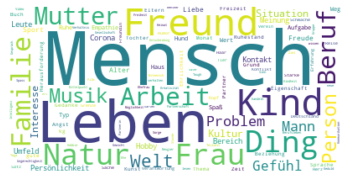

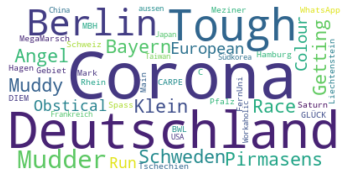

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline

pos = ("NOUN", "PROPN")
text = get_text_by_pos(df_study1["text_spacy_doc_filtered"], pos, lemma=True)
wordcloud = build_wordcloud(text, as_image=False)

plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

pos = ("PROPN")
text = get_text_by_pos(df_study1["text_spacy_doc_filtered"], pos, lemma=True)
wordcloud = build_wordcloud(text, as_image=False)

plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

WordCloud: ('NOUN', 'PROPN')


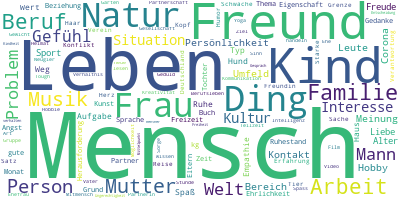

In [15]:
# https://universaldependencies.org/u/pos/
pos = ("NOUN",)
pos = ("NOUN", "PROPN")
#pos = ("VERB",)
#pos = ("ADJ",)

text = get_text_by_pos(df_study1["text_spacy_doc_filtered"], pos, lemma=True)
print(f"WordCloud: {pos}")
build_wordcloud(text)

WordCloud: ('NOUN', 'PROPN'); power <= 3


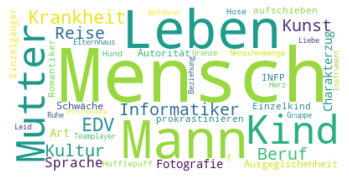

WordCloud: ('NOUN', 'PROPN'); power >= 5


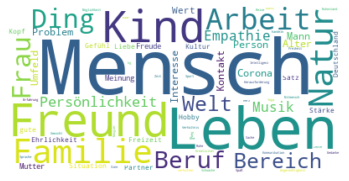

In [25]:
# https://universaldependencies.org/u/pos/
pos = ("NOUN",)
pos = ("NOUN", "PROPN")
#pos = ("VERB",)
#pos = ("ADJ",)

df_sub = df_study1[df_study1["power"] <= 3]["text_spacy_doc_filtered"]
text = get_text_by_pos(df_sub, pos, lemma=True)
print(f"WordCloud: {pos}; power <= 3")
wordcloud = build_wordcloud(text, as_image=False)

plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

df_sub = df_study1[df_study1["power"] >= 5]["text_spacy_doc_filtered"]
text = get_text_by_pos(df_sub, pos, lemma=True)
print(f"WordCloud: {pos}; power >= 5")
wordcloud = build_wordcloud(text, as_image=False)

plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

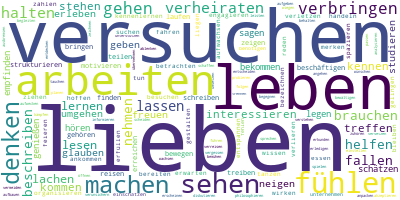

In [ ]:
pos = ("VERB",)
text = get_text_by_pos(df_study1["text_spacy_doc_filtered"], pos, lemma=True)
build_wordcloud(text)

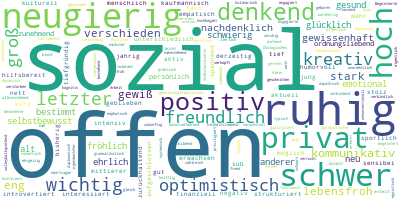

In [ ]:
pos = ("ADJ",)
text = get_text_by_pos(df_study1["text_spacy_doc_filtered"], pos, lemma=True)
build_wordcloud(text)

### Frequency Comparison

In [163]:
def make_word_freq_df(df, by="power", pos=("NOUN",), lemma=True, max_freq=None, min_freq=10):
    row = df_study1[by].map(round)

    dfs = []
    for score in range(1, 8):
        mask = row == score
        df_sub = df[row == score]["text_spacy_doc_filtered"]
        tokens = get_tokens_by_pos(df_sub, pos_list=pos, lemma=lemma, join=True)
        cnt = collections.Counter(tokens)

        df_score = pd.DataFrame.from_dict(cnt, orient='index').rename(columns={0: f"{by}={score}"})
        dfs.append(df_score)

    df_scores = pd.concat(dfs, axis=1).fillna(0)
    df_scores["_total"] = df_scores.sum(axis=1)
    df_scores = df_scores.sort_values("_total", ascending=False)
    if max_freq is not None:
        df_scores = df_scores[df_scores["_total"] <= max_freq]    
    if min_freq is not None:
        df_scores = df_scores[df_scores["_total"] >= min_freq]
    del df_scores["_total"]

    return df_scores

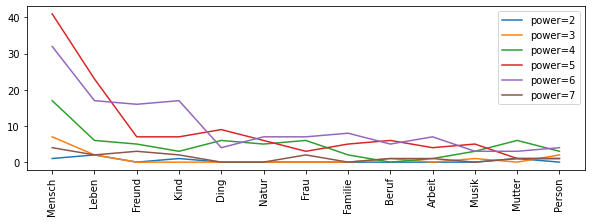

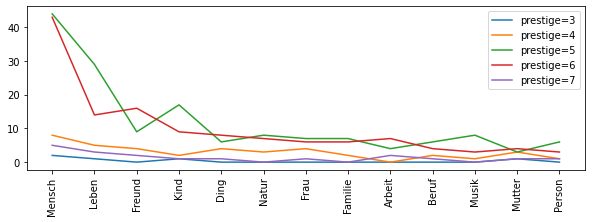

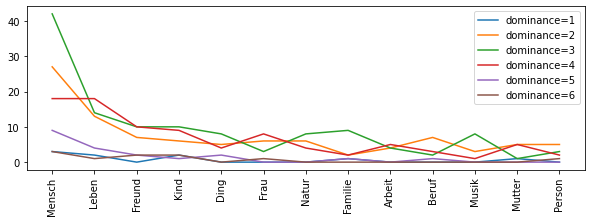

In [169]:
min_freq = 10

df_scores = make_word_freq_df(df_study1, by="power", min_freq=min_freq)
#df_scores = df_scores.sort_values("power=5", ascending=False)
df_scores.plot(kind="line", figsize=(10, 3), rot=90, xticks=list(range(len(df_scores.index))))

df_scores = make_word_freq_df(df_study1, by="prestige", min_freq=min_freq)
#df_scores = df_scores.sort_values("prestige=5", ascending=False)
df_scores.plot(kind="line", figsize=(10, 3), rot=90, xticks=list(range(len(df_scores.index))))

df_scores = make_word_freq_df(df_study1, by="dominance", min_freq=min_freq)
#df_scores = df_scores.sort_values("dominance=5", ascending=False)
df_scores.plot(kind="line", figsize=(10, 3), rot=90, xticks=list(range(len(df_scores.index))))

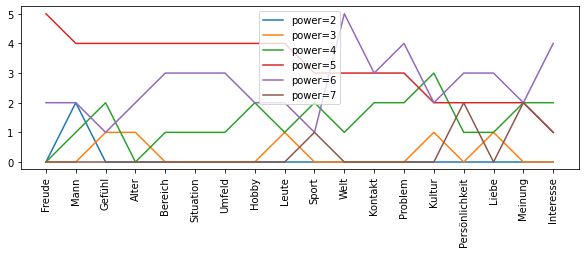

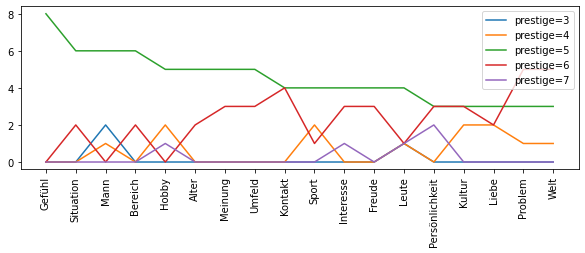

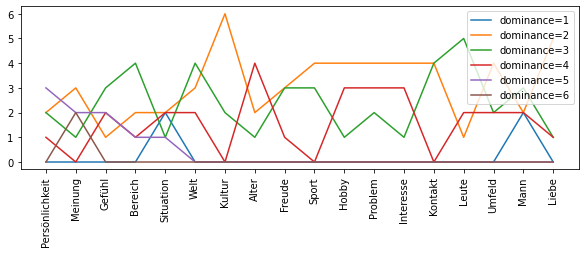

In [170]:
max_freq = 10
min_freq = 7

df_scores = make_word_freq_df(df_study1, by="power", max_freq=max_freq, min_freq=min_freq)
df_scores = df_scores.sort_values("power=5", ascending=False)
df_scores.plot(kind="line", figsize=(10, 3), rot=90, xticks=list(range(len(df_scores.index))))

df_scores = make_word_freq_df(df_study1, by="prestige", max_freq=max_freq, min_freq=min_freq)
df_scores = df_scores.sort_values("prestige=5", ascending=False)
df_scores.plot(kind="line", figsize=(10, 3), rot=90, xticks=list(range(len(df_scores.index))))

df_scores = make_word_freq_df(df_study1, by="dominance", max_freq=max_freq, min_freq=min_freq)
df_scores = df_scores.sort_values("dominance=5", ascending=False)
df_scores.plot(kind="line", figsize=(10, 3), rot=90, xticks=list(range(len(df_scores.index))))

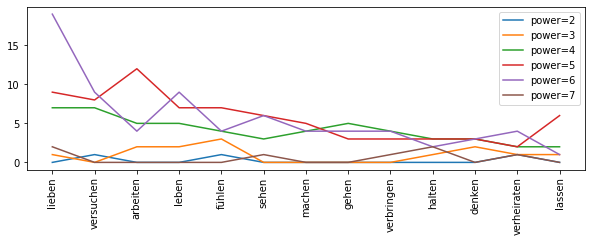

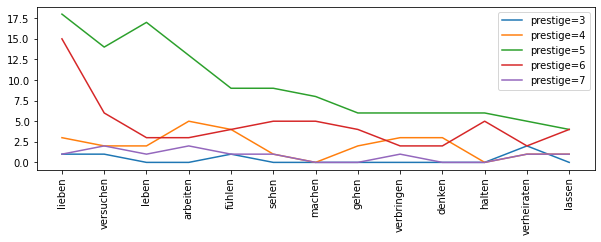

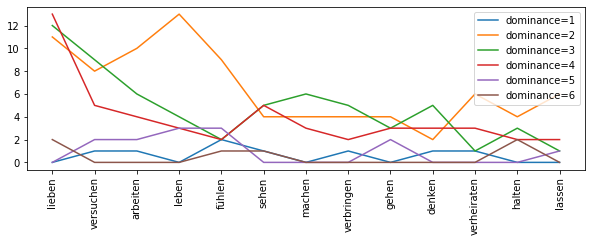

In [171]:
min_freq = 10
pos = ("VERB",)

df_scores = make_word_freq_df(df_study1, by="power", pos=pos, min_freq=min_freq)
#df_scores = df_scores.sort_values("power=5", ascending=False)
df_scores.plot(kind="line", figsize=(10, 3), rot=90, xticks=list(range(len(df_scores.index))))

df_scores = make_word_freq_df(df_study1, by="prestige", pos=pos, min_freq=min_freq)
#df_scores = df_scores.sort_values("prestige=5", ascending=False)
df_scores.plot(kind="line", figsize=(10, 3), rot=90, xticks=list(range(len(df_scores.index))))

df_scores = make_word_freq_df(df_study1, by="dominance", pos=pos, min_freq=min_freq)
#df_scores = df_scores.sort_values("dominance=5", ascending=False)
df_scores.plot(kind="line", figsize=(10, 3), rot=90, xticks=list(range(len(df_scores.index))))

low:  14
mid:  117
high:  69


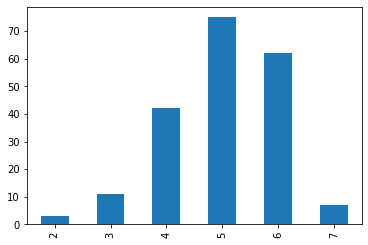

In [78]:
powers = df_study1["power"].map(round)

#mask_low = ((df_study1["power"] >= 0) & (df_study1["power"] <= 3))
mask_low = powers.isin([1, 2, 3])
mask_mid = powers.isin([4, 5])
mask_high = powers.isin([6, 7])

print("low: ", len(df_study1[mask_low]["text_spacy_doc_filtered"]))
print("mid: ", len(df_study1[mask_mid]["text_spacy_doc_filtered"]))
print("high: ", len(df_study1[mask_high]["text_spacy_doc_filtered"]))

powers.value_counts().sort_index().plot(kind="bar")

[('Mensch', 8), ('Leben', 4), ('Mann', 2), ('Person', 2), ('Entscheidung', 2)]
[('Mensch', 58), ('Leben', 29), ('Ding', 15), ('Freund', 12), ('Natur', 11), ('Kind', 10), ('Frau', 9), ('Musik', 8), ('Mutter', 7), ('Familie', 7)]
[('Mensch', 36), ('Freund', 19), ('Leben', 19), ('Kind', 19), ('Frau', 9), ('Familie', 8), ('Arbeit', 8), ('Natur', 7), ('Beruf', 6), ('Interesse', 5)]


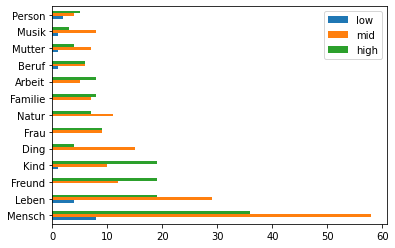

In [124]:
pos = ("NOUN", "PROPN")
lemma = True

df = df_study1[mask_low]["text_spacy_doc_filtered"]
tokens_low = get_tokens_by_pos(df, pos_list=pos, lemma=lemma, join=True)
cnt_low = collections.Counter(tokens_low)
print([(w, n) for w, n in cnt_low.most_common(10) if n > 1])

df = df_study1[mask_mid]["text_spacy_doc_filtered"]
tokens_mid = get_tokens_by_pos(df, pos_list=pos, lemma=lemma, join=True)
cnt_mid = collections.Counter(tokens_mid)
print([(w, n) for w, n in cnt_mid.most_common(10) if n > 1])

df = df_study1[mask_high]["text_spacy_doc_filtered"]
tokens_high = get_tokens_by_pos(df, pos_list=pos, lemma=lemma, join=True)
cnt_high = collections.Counter(tokens_high)
print([(w, n) for w, n in cnt_high.most_common(10) if n > 1])

df_low = pd.DataFrame.from_dict(cnt_low, orient='index').rename(columns={0: "low"})#.reset_index()
df_mid = pd.DataFrame.from_dict(cnt_mid, orient='index').rename(columns={0: "mid"})#.reset_index()
df_high = pd.DataFrame.from_dict(cnt_high, orient='index').rename(columns={0: "high"})#.reset_index()

df_lmh = pd.concat([df_low, df_mid, df_high], axis=1).fillna(0)
df_lmh["_total"] = df_lmh.sum(axis=1)
df_lmh = df_lmh.sort_values("_total", ascending=False)
df_lmh = df_lmh[df_lmh["_total"] >= 10]
del df_lmh["_total"]

df_lmh.plot(kind="barh")

### Topic-Models: LDA, HDP, ...

- [pyLDAvis_overview.ipynb](https://nbviewer.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb)
- [HN Topic Model Talk.ipynb](https://nbviewer.org/github/bmabey/hacker_news_topic_modelling/blob/master/HN%20Topic%20Model%20Talk.ipynb)
- https://speakerdeck.com/bmabey/visualizing-topic-models !

In [ ]:
import gensim
import nltk
from gensim.corpora import Dictionary, MmCorpus

In [ ]:
%%time
# load data
df_study1 = load_study1()
df_study2 = load_study2()

# tokenize, postag, ...
df_study1["text_spacy_doc"] = nlpize(df_study1["text"], nlp)
df_study2["text_spacy_doc"] = nlpize(df_study2["text"], nlp)

CPU times: user 2min 15s, sys: 672 ms, total: 2min 16s
Wall time: 2min 19s


In [ ]:
%%time
# remove punctuation
do_clean_stopwords = True
df_study1["text_spacy_doc_filtered"] = clean(df_study1["text_spacy_doc"], stopwords=do_clean_stopwords, alpha=False, punctuation=True)
df_study2["text_spacy_doc_filtered"] = clean(df_study2["text_spacy_doc"], stopwords=do_clean_stopwords, alpha=False, punctuation=True)

# take raw text `tok.text` instead of lemma `tok.lemma_`
df_study1["tokens"] = df_study1["text_spacy_doc_filtered"].map(lambda doc: list(map(lambda tok: tok.text, doc)))
df_study2["tokens"] = df_study2["text_spacy_doc_filtered"].map(lambda doc: list(map(lambda tok: tok.text, doc)))
# convert to plain string
df_study1["tokens"] = df_study1["tokens"].map(lambda doc: list(map(str, doc)))
df_study2["tokens"] = df_study2["tokens"].map(lambda doc: list(map(str, doc)))

# concat both studies
docs = pd.concat([df_study1["tokens"], df_study2["tokens"]], ignore_index=True)
docs_raw = docs.map(lambda doc: " ".join(doc))

#### Compute model

- https://nbviewer.org/github/bmabey/pyLDAvis/blob/master/notebooks/Gensim%20Newsgroup.ipynb

In [ ]:
def nltk_stopwords():
    return set(nltk.corpus.stopwords.words('german'))


def prep_corpus(docs, stopwords=None, no_below=5, no_above=0.5):
    print('Building dictionary...')
    dictionary = Dictionary(docs)
    if stopwords:
      stopword_ids = map(dictionary.token2id.get, stopwords)
      dictionary.filter_tokens(stopword_ids)
    dictionary.compactify()
    dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=None)
    dictionary.compactify()

    print('Building corpus...')
    corpus = [dictionary.doc2bow(doc) for doc in docs]

    return dictionary, corpus

In [ ]:
stopwords = set(nltk.corpus.stopwords.words('german'))
stopwords = stopwords.union(set())  # additional stopwords

In [ ]:
%%time
# build dictionary and corpus
stopwords = set()  # comment out to remove stopwords
dictionary, corpus = prep_corpus(docs, stopwords, no_below=2, no_above=0.5)

# store
MmCorpus.serialize("study1.mm", corpus)
dictionary.save("study1.dict")

In [ ]:
%%time
# compute topic model
lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=25, passes=20)
# store
lda.save("study1.lda_model")

In [ ]:
%%time
hdp = gensim.models.hdpmodel.HdpModel(corpus, dictionary, T=30)
hdp.save("study1.hdp_model")

#### visualize model

In [ ]:
# load model
import os.path

dictionary = gensim.corpora.Dictionary.load("study1.dict")
corpus = gensim.corpora.MmCorpus("study1.mm")
if os.path.exists("study1.lda_model"):
    lda = gensim.models.ldamodel.LdaModel.load("study1.lda_model")
if os.path.exists("study1.hdp_model"):
    hdp = gensim.models.ldamodel.LdaModel.load("study1.hdp_model")

In [ ]:
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [ ]:
# schläg fehl bei Stopwort-Removal?
vis_data = gensimvis.prepare(hdp, corpus, dictionary)
pyLDAvis.display(vis_data)

In [ ]:
lda.show_topics()

[(2,
  '0.021*"positiv" + 0.014*"fühle" + 0.014*"gerne" + 0.014*"arbeiten" + 0.014*"Basis" + 0.014*"halte" + 0.014*"Entwicklung" + 0.014*"Mensch" + 0.014*"denkender" + 0.014*"empathisch"'),
 (17,
  '0.031*"Menschen" + 0.019*"Umgang" + 0.018*"Tätigkeit" + 0.017*"Kollegen" + 0.017*"bewertet" + 0.014*"Bewertung" + 0.013*"wichtig" + 0.011*"Mitarbeiter" + 0.011*"Tätigkeiten" + 0.011*"freundlich"'),
 (18,
  '0.024*"sehe" + 0.018*"verschiedenen" + 0.018*"unterstützen" + 0.018*"Projekt" + 0.018*"Schule" + 0.012*"arbeite" + 0.012*"Kollegen" + 0.012*"beraten" + 0.012*"Aufgabe" + 0.012*"SchülerInnen"'),
 (8,
  '0.037*"gerne" + 0.021*"Menschen" + 0.016*"Tätigkeit" + 0.011*"Planung" + 0.011*"Arbeiten" + 0.011*"eher" + 0.009*"freundlich" + 0.009*"Tätigkeiten" + 0.009*"gehe" + 0.007*"glücklich"'),
 (6,
  '0.023*"gerne" + 0.015*"liebe" + 0.015*"Mensch" + 0.013*"Probleme" + 0.013*"interessiert" + 0.010*"Bereich" + 0.010*"versuche" + 0.010*"eher" + 0.010*"Familie" + 0.009*"manchmal"'),
 (16,
  '0.036*"\

In [ ]:
hdp.show_topics()

[(0,
  '0.006*Kreativität + 0.005*Welt + 0.004*schwierig + 0.004*Hilfestellung + 0.004*Austausch + 0.004*fit + 0.004*Freund + 0.004*hinein + 0.004*treten + 0.004*IT + 0.004*Pensionär + 0.004*neugierig + 0.004*Gruppen + 0.004*Vorgaben + 0.003*kommunikative + 0.003*netter + 0.003*Bewertung + 0.003*technische + 0.003*zuständig + 0.003*beschäftigen'),
 (1,
  '0.006*arbeite + 0.005*vertraulich + 0.004*fördern + 0.004*Produkte + 0.004*Daten + 0.004*diverse + 0.004*Arbeit + 0.004*nachdenklich + 0.004*schafft + 0.004*Flexibilität + 0.004*lustig + 0.003*fordernd + 0.003*einerseits + 0.003*schlank + 0.003*Haus + 0.003*normalerweise + 0.003*Publikation + 0.003*Unternehmen + 0.003*persönlichen + 0.003*stellen'),
 (2,
  '0.007*Vorgaben + 0.006*halte + 0.005*Teamwork + 0.004*Verhältnis + 0.004*gelegt + 0.004*Freundinnen + 0.004*warmherzig + 0.004*begleiten + 0.004*versorge + 0.004*kennenzulernen + 0.004*professionell + 0.003*komplette + 0.003*u.a. + 0.003*abzustimmen + 0.003*beschäftige + 0.003*Orga

#### sklearn models

- https://nbviewer.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(docs_raw)
print(dtm_tf.shape)

(400, 104)


In [ ]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)
print(dtm_tfidf.shape)

(400, 104)


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:2032: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  UserWarning,


In [ ]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tf.fit(dtm_tf)

# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(n_components=20, random_state=0)

In [ ]:
vis_data = sklearnvis(lda_tf, dtm_tf, tf_vectorizer)
pyLDAvis.display(vis_data)

In [ ]:
vis_data = sklearnvis(lda_tfidf, dtm_tfidf, tfidf_vectorizer)
pyLDAvis.display(vis_data)

In [ ]:
# mmds / tsne
vis_data = pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer, mds='tsne')
pyLDAvis.display(vis_data)

## other stuff